# DAT300 - Compulsory assignment 2

## Group 2
#### Fight Club Goofy Edition

## Orion username:
#### dat300-22-9
  
## Members
- Joel Yacob
- Artush Mkrtchyan

# Introduction

The problem that we are going to solve is to differantiate between roads and everything else using pictures of roads as training data. The pictures have three channels; red, green and blue. The different parts in the pictures are already classified, therefore we have to make this a binary problem where roads are categorised as one thing, while everything else falls under another category called 'other'. 

We are then going to use U-net and tune the parameters to then train the model. After that we are going to use VGG16 and compare that method with the manual U-net to see which model performed the best. 

And last, but not least, we are going to upload these models to Orion and see if there is any difference in accuracy and total time used.

# Data handling and visualisation

In [1]:
# Import and extraction of data.
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd

from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from keras import backend as K
from keras.applications.vgg16 import VGG16 as vg, preprocess_input

As seen below, we are defining the training and testing data

In [2]:
train_data = h5py.File("../input/ca2-test-and-train/train.h5")
test_data = h5py.File("../input/ca2-test-and-train/test.h5")

In [3]:
print(train_data.keys())
print(test_data.keys())

<KeysViewHDF5 ['X', 'y']>
<KeysViewHDF5 ['X']>


In [4]:
X = train_data["X"][:]
y = train_data["y"][:]

X_test_final = test_data["X"][:]

In [38]:
print("Shape of X: ", X.shape)
print("Shape of y: ", y.shape)
print("Shape of X_test_final: ", X_test_final.shape)

Shape of X:  (2780, 128, 128, 3)
Shape of y:  (2780, 128, 128, 1)
Shape of X_test_final:  (695, 128, 128, 3)


As seen on shape of X, the pictures are all 128 x 128 with 3 channels.

In [6]:
# Short exploration and visualisation of dataset (point 1 in Canvas).
print("Height of image: ",X.shape[1])
print("Width of image: ",X.shape[2])
print("Channels of image: ",X.shape[3])

Height of image:  128
Width of image:  128
Channels of image:  3


The code below is to show the three channels, the original picture and how the differnt parts are segmentated.

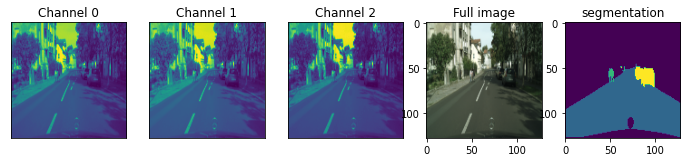

In [7]:
fig, ax = plt.subplots(1,5, figsize=(12,12))

for i , axis in enumerate(ax[:3]):
    axis.imshow(X[0][:,:,i])
    axis.title.set_text(f'Channel {i}')
    axis.set_xticks([])
    axis.set_yticks([])

ax[3].imshow(X[0])
ax[3].title.set_text("Full image")

ax[4].imshow(y[0])
ax[4].title.set_text("segmentation")

plt.show()

In channel 0, we see where there are most reds, in channel 1 the same but with greens, and channel 2 with blues. The last picture shows the segmentation of the different parts (cars, roads, people and other things).

# Methods

Since the dataset was particularly large, we did not perform gridsearch and such strategies to get better tuned hyperparameters. Other than splitting the dataset for training and testing, we did not use much advanced methods for this task. 

We first tried a 2D U-Net, then we combined our U-Net with the pretrained VGG16 for a better result. The last method we used was multiclass segmentation with U-Net, we had to convert our U-Net function to a 3D approach.

# Preprocessing

Splitting into train and test using the train data before transforming the train labels into a binary problem.

In [8]:
# Code for preprocessing of the data and transformation of labels for the binary problem (Point 2 in Canvas)

y = np.where(y != 0, 1,0) # Transform the train labels into a binary problem

X_train, X_test, y_train, y_test = train_test_split(
    X,y, test_size=0.1, random_state=69)

# Results

#### Functions of U-net below:

In [9]:
# Code and model training for your best Basic U-Net model (point 3 in Canvas)

def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x


def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True, n_classes = 2):
    
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(n_classes, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [10]:
input_img = Input(shape=(128,128,3))
model = get_unet(input_img, n_filters = 32, dropout = 0.1, batchnorm = True, n_classes = 1)
model.summary()

2022-11-09 12:04:05.515727: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-09 12:04:05.516780: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-09 12:04:05.864303: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-09 12:04:05.865158: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-09 12:04:05.865920: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [11]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [12]:
model.compile(optimizer = "Adam", loss = "binary_crossentropy", metrics = ['acc',f1_m]) # precision_m, recall_m
callback = EarlyStopping(monitor="loss", patience=5)

In [13]:
var = model.fit(X_train, y_train, epochs=50, callbacks = callback, validation_data=(X_test, y_test))

2022-11-09 12:04:11.891639: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 491913216 exceeds 10% of free system memory.
2022-11-09 12:04:12.424395: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 327942144 exceeds 10% of free system memory.
2022-11-09 12:04:12.827627: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 491913216 exceeds 10% of free system memory.
2022-11-09 12:04:13.219286: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 327942144 exceeds 10% of free system memory.
2022-11-09 12:04:13.522752: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-11-09 12:04:17.909853: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


79/79 [==============================] - 37s 234ms/step - loss: 0.2396 - acc: 0.9032 - f1_m: 0.9277 - val_loss: 0.9053 - val_acc: 0.7464 - val_f1_m: 0.8364
Epoch 2/50
79/79 [==============================] - 15s 194ms/step - loss: 0.1500 - acc: 0.9415 - f1_m: 0.9568 - val_loss: 1.2142 - val_acc: 0.7168 - val_f1_m: 0.8260
Epoch 3/50
79/79 [==============================] - 15s 195ms/step - loss: 0.1215 - acc: 0.9531 - f1_m: 0.9655 - val_loss: 0.2202 - val_acc: 0.9163 - val_f1_m: 0.9392
Epoch 4/50
79/79 [==============================] - 16s 198ms/step - loss: 0.1140 - acc: 0.9563 - f1_m: 0.9678 - val_loss: 0.1820 - val_acc: 0.9407 - val_f1_m: 0.9567
Epoch 5/50
79/79 [==============================] - 16s 200ms/step - loss: 0.0984 - acc: 0.9615 - f1_m: 0.9717 - val_loss: 0.1435 - val_acc: 0.9513 - val_f1_m: 0.9640
Epoch 6/50
79/79 [==============================] - 16s 203ms/step - loss: 0.0925 - acc: 0.9642 - f1_m: 0.9733 - val_loss: 0.1041 - val_acc: 0.9640 - val_f1_m: 0.9730
Epoch 7/5

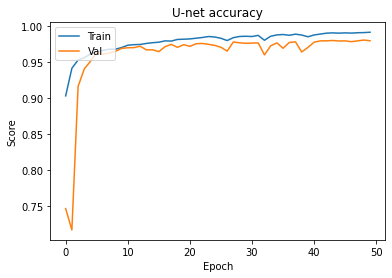

In [14]:
# Plot of the accuracy of the U-net model over each epoch

plt.plot(var.history['acc'])
plt.plot(var.history['val_acc'])
plt.title('U-net accuracy')
plt.ylabel('Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

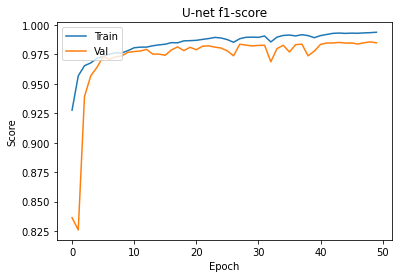

In [15]:
# Plot of the f1-score of the U-net model over each epoch

plt.plot(var.history['f1_m'])
plt.plot(var.history['val_f1_m'])
plt.title('U-net f1-score')
plt.ylabel('Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

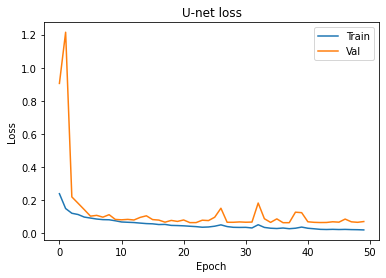

In [16]:
#Plot of the loss of the U-net model over each epoch

plt.plot(var.history['loss'])
plt.plot(var.history['val_loss'])
plt.title('U-net loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

One can see that the training accuracy and f1-score is a small bit higher than the validation score. This means that the manual U-net model overfits a tiny bit. Furthermore, one can see that the loss gets smaller for each epoch.

In [17]:
# Code and model training for your best transfer learning model (point 4 in Canvas)

def get_unet_vg16(input_img, n_filters = 16, dropout = 0.1, batchnorm = True, n_classes = 2):
    
    encode_model = vg(input_tensor=input_img, include_top = False, weights="imagenet")
    
    for layer in encode_model.layers:
        layer.trainable = False
        
    encoder_output = encode_model.get_layer("block5_conv3").output
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(encoder_output)
    u6 = concatenate([u6, encode_model.get_layer("block4_conv3").output])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, encode_model.get_layer("block3_conv3").output])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, encode_model.get_layer("block2_conv2").output])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, encode_model.get_layer("block1_conv2").output])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs_vg = Conv2D(n_classes, (1, 1), padding = 'same', activation='sigmoid')(c9)
    vg_model = Model(inputs=[encode_model.input], outputs=[outputs_vg])
    return vg_model

In [18]:
input_img = Input(shape=(128,128,3))
model_vg = get_unet_vg16(input_img, n_filters = 64, dropout = 0.2, batchnorm = True, n_classes = 1)
model_vg.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 128, 128, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 128, 128, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 64, 64, 64)   0           block1_conv2[0][0]               
___________________________

In [19]:
inputs = Input((128,128,3))
model_vg.compile(optimizer = Adam(learning_rate = 0.001), loss = "binary_crossentropy", metrics = ['acc',f1_m]) # precision_m, recall_m
# Fit data to model

history = model_vg.fit(X_train, y_train,
                       epochs=50,
                       batch_size=42,
                      # shuffle=True,
                       validation_data=(X_test, y_test),
                       callbacks= callback
             )

2022-11-09 12:18:12.148071: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 491913216 exceeds 10% of free system memory.


Epoch 1/50
60/60 [==============================] - 57s 732ms/step - loss: 0.2168 - acc: 0.9089 - f1_m: 0.9308 - val_loss: 1.1796 - val_acc: 0.9323 - val_f1_m: 0.9485
Epoch 2/50
60/60 [==============================] - 32s 528ms/step - loss: 0.1299 - acc: 0.9483 - f1_m: 0.9617 - val_loss: 0.2013 - val_acc: 0.9489 - val_f1_m: 0.9615
Epoch 3/50
60/60 [==============================] - 32s 530ms/step - loss: 0.1127 - acc: 0.9552 - f1_m: 0.9669 - val_loss: 0.1433 - val_acc: 0.9525 - val_f1_m: 0.9641
Epoch 4/50
60/60 [==============================] - 32s 531ms/step - loss: 0.1032 - acc: 0.9593 - f1_m: 0.9700 - val_loss: 0.1274 - val_acc: 0.9591 - val_f1_m: 0.9695
Epoch 5/50
60/60 [==============================] - 32s 530ms/step - loss: 0.0925 - acc: 0.9634 - f1_m: 0.9729 - val_loss: 0.1229 - val_acc: 0.9582 - val_f1_m: 0.9692
Epoch 6/50
60/60 [==============================] - 32s 529ms/step - loss: 0.0836 - acc: 0.9667 - f1_m: 0.9755 - val_loss: 0.0883 - val_acc: 0.9664 - val_f1_m: 0.975

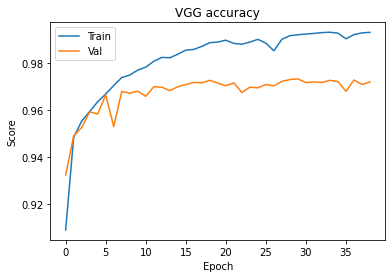

In [20]:
# Plot of the accuracy of the VGG model over each epoch

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('VGG accuracy')
plt.ylabel('Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

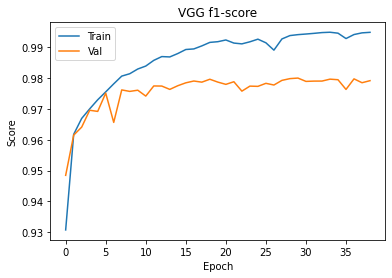

In [21]:
# Plot of the f1-score of the VGG model over each epoch

plt.plot(history.history['f1_m'])
plt.plot(history.history['val_f1_m'])
plt.title('VGG f1-score')
plt.ylabel('Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

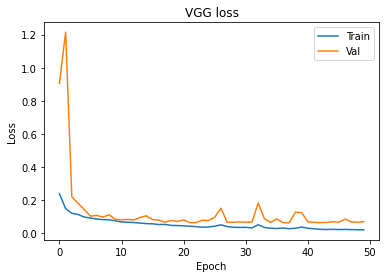

In [22]:
#Plot of the loss of the VGG model over each epoch

plt.plot(var.history['loss'])
plt.plot(var.history['val_loss'])
plt.title('VGG loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

#### One can see that the VGG model overfits much more than the manual U-net model

### Orion related code, i.e. slurm-script, username, code to access data on Orion and time usage for your modelling (point 5)

#### Slurm script: singularity exec --nv --bind /mnt/courses/DAT300-22:/mnt/courses/DAT300-22 $SIFFILE python Unet-CA2-Orion.py

From what we see, Orion was a little bit faster at training the models and predicting

In [23]:
# Optional: Code and model training for multiclass segmentation with U-net (Point 5 in Canvas)

Describe the results you are observing.

In [24]:
unet_predictions = model.predict(X_test_final) # U-net predicting
pred_1 = unet_predictions.flatten()
pred_1

vg_predictions = model_vg.predict(X_test_final) # VGG16 predicting
pred_2 = vg_predictions.flatten()
pred_2

array([0.9989022 , 0.9969715 , 0.9989262 , ..., 0.9999335 , 0.99993956,
       0.9996289 ], dtype=float32)

In [ ]:
submission_df = pd.DataFrame(data=list(range(len(pred))), 
                             columns=["Id"])

submission_df["Predicted"] = pred
submission_df = submission_df.round(0).astype("int")
                                    
submission_df['Predicted'] = np.where(submission_df['Predicted'] == 0,
                                      False, True)

submission_df.to_csv("CA2_goofy_submission.csv", index=False)
submission_df

# Discussion / conclusion

When we started modelling, we didn't change the output activation from softmax to sigmoid, which gave us an accuracy of around 60%. After changing this to sigmoid, our accuracy got much better on around 80%, but didn't really excel around 98% until we changed our preprocessing method. By using sklearn's train-test-split, we managed to get above beat me. We also had some problems with Orion, because it did not have sklearn and had a steep learning curve, because of the linux commands.

Our best model was the manual U-net, which was a little bit better than VGG, since it didn't overfit as much. Anyway, when running the models in Orion, each epoch for both of the models took less time to run, but the overall accuracy stayed the same. Given that Orion did not work for us for quite a long time, this increase in speed did not help us much. 

In other words, we did not have a pleasant experience with Orion. Anyway, given more time we would commit to complete the optional task of multiclass segmentation. We did manage to make the function work, but we did not understand how to fit that to the model. We have therefore concluded with not including it in this compulsary assignment.